In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw

import math
import re
from collections import Counter
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

In [ ]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

In [ ]:
# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 24.4MB/s]


In [ ]:
path = "/content/"

NUMBER_OF_PLATES = 600

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You will need to update this path to match the folder in your Google Drive
PATH = "/content/pictures/"
labels_raw = !ls "{PATH}"

labels = []
for i in range(0, len(labels_raw)):
  labels += labels_raw[i].split()
print(labels)

['plate_AA00.png', 'plate_FF54.png', 'plate_KM66.png', 'plate_PX52.png', 'plate_UD26.png', 'plate_AA34.png', 'plate_FG03.png', 'plate_KN96.png', 'plate_PY51.png', 'plate_UD32.png', 'plate_AC50.png', 'plate_FI92.png', 'plate_KO50.png', 'plate_PY52.png', 'plate_UE29.png', 'plate_AD33.png', 'plate_FK40.png', 'plate_KQ10.png', 'plate_PY84.png', 'plate_UE38.png', 'plate_AD69.png', 'plate_FM51.png', 'plate_KQ28.png', 'plate_PZ24.png', 'plate_UE44.png', 'plate_AH01.png', 'plate_FM79.png', 'plate_KQ69.png', 'plate_PZ33.png', 'plate_UF01.png', 'plate_AI22.png', 'plate_FN75.png', 'plate_KQ95.png', 'plate_PZ52.png', 'plate_UF55.png', 'plate_AI41.png', 'plate_FO60.png', 'plate_KR14.png', 'plate_PZ72.png', 'plate_UG00.png', 'plate_AK24.png', 'plate_FP36.png', 'plate_KS25.png', 'plate_PZ84.png', 'plate_UH31.png', 'plate_AL98.png', 'plate_FP57.png', 'plate_KT16.png', 'plate_QA62.png', 'plate_UI88.png', 'plate_AN06.png', 'plate_FR32.png', 'plate_KT37.png', 'plate_QA79.png', 'plate_UJ25.png', 'plate_AN

In [ ]:
image_paths = []
plates = []

for label in labels:
  image_paths.append(PATH + label)
  plates.append(label[6:10])

print(image_paths)
print(plates)

['/content/pictures/plate_AA00.png', '/content/pictures/plate_FF54.png', '/content/pictures/plate_KM66.png', '/content/pictures/plate_PX52.png', '/content/pictures/plate_UD26.png', '/content/pictures/plate_AA34.png', '/content/pictures/plate_FG03.png', '/content/pictures/plate_KN96.png', '/content/pictures/plate_PY51.png', '/content/pictures/plate_UD32.png', '/content/pictures/plate_AC50.png', '/content/pictures/plate_FI92.png', '/content/pictures/plate_KO50.png', '/content/pictures/plate_PY52.png', '/content/pictures/plate_UE29.png', '/content/pictures/plate_AD33.png', '/content/pictures/plate_FK40.png', '/content/pictures/plate_KQ10.png', '/content/pictures/plate_PY84.png', '/content/pictures/plate_UE38.png', '/content/pictures/plate_AD69.png', '/content/pictures/plate_FM51.png', '/content/pictures/plate_KQ28.png', '/content/pictures/plate_PZ24.png', '/content/pictures/plate_UE44.png', '/content/pictures/plate_AH01.png', '/content/pictures/plate_FM79.png', '/content/pictures/plate_KQ

In [ ]:
gray_plates = []
for path in image_paths:
  plate = cv2.imread(path)
  gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
  gray_plates.append(gray_plate)

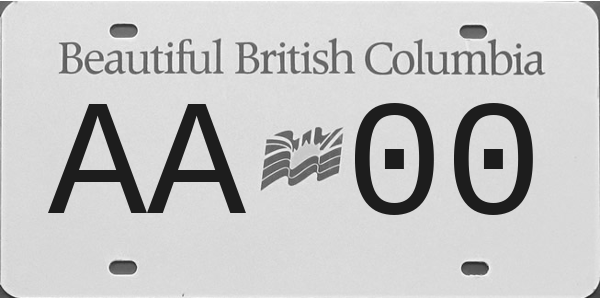

In [ ]:
cv2_imshow(gray_plates[0])

In [ ]:
height = gray_plates[0].shape[0]
width = gray_plates[0].shape[1]
print(height)
print(width)

298
600


In [ ]:
def split_plates(plate):
  first_letter = plate[80:250,40:150]
  second_letter = plate[80:250,150:260]
  third_letter = plate[80:250,340:450]
  fourth_letter = plate[80:250,450:560]
  return first_letter, second_letter, third_letter, fourth_letter

In [ ]:
from ipywidgets.widgets.interaction import check_argspec
from matplotlib.afm import CharMetrics

# splits each license plate string into a individual characters and adds them to a list
def split_chars(plates):
  split = []
  for plate in plates:
    for i in range(0, len(plate)):
      split.append(plate[i])
  return split

# adds each character to the chars list in the same order as the images in the char_imgs list
chars = split_chars(plates)

In [ ]:
chars_new = 0

In [ ]:
def processor1(image):
    im = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    _, bin_im = cv2.threshold(im, 190, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    small = cv2.resize(bin_im, (0, 0), fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    _, bin_small = cv2.threshold(small, 80, 255, cv2.THRESH_BINARY)
    large = cv2.resize(bin_small, (110, 170), interpolation=cv2.INTER_NEAREST)
    _, bin_large = cv2.threshold(large, 190, 255, cv2.THRESH_BINARY)
    return bin_large

In [ ]:
def processor2(image):
    im = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    _, bin_im = cv2.threshold(im, 190, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    small = cv2.resize(bin_im, (0, 0), fx=0.8, fy=0.8, interpolation = cv2.INTER_LINEAR)
    _, bin_small = cv2.threshold(small, 80, 255, cv2.THRESH_BINARY)
    large = cv2.resize(bin_small, (110, 170), interpolation=cv2.INTER_NEAREST)
    _, bin_large = cv2.threshold(large, 190, 255, cv2.THRESH_BINARY)
    return bin_large

In [ ]:
def processor3(image):
    im = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    _, bin_im = cv2.threshold(im, 190, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    small = cv2.resize(bin_im, (0, 0), fx=0.15, fy=0.15, interpolation = cv2.INTER_LINEAR)
    _, bin_small = cv2.threshold(small, 80, 255, cv2.THRESH_BINARY)
    large = cv2.resize(bin_small, (110, 170), interpolation=cv2.INTER_NEAREST)
    _, bin_large = cv2.threshold(large, 190, 255, cv2.THRESH_BINARY)
    return bin_large

In [ ]:
def processor4(image):
    im = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    _, bin_im = cv2.threshold(im, 190, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    small = cv2.resize(bin_im, (0, 0), fx=0.3, fy=0.3, interpolation = cv2.INTER_LINEAR)
    _, bin_small = cv2.threshold(small, 80, 255, cv2.THRESH_BINARY)
    large = cv2.resize(bin_small, (110, 170), interpolation=cv2.INTER_NEAREST)
    _, bin_large = cv2.threshold(large, 190, 255, cv2.THRESH_BINARY)
    return bin_large

In [ ]:
def split_new(list):
  split = []
  for plate in list:
    first_letter = plate[80:250,40:150]
    split.append(processor4(first_letter))
    second_letter = plate[80:250,150:260]
    split.append(processor1(second_letter))
    third_letter = plate[80:250,340:450]
    split.append(processor2(third_letter))
    fourth_letter = plate[80:250,450:560]
    split.append(processor3(fourth_letter))
  return split

chars_new = split_new(gray_plates)

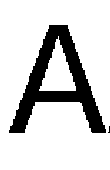

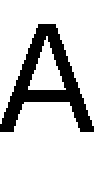

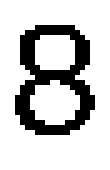

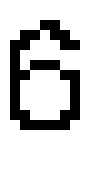

In [ ]:
cv2_imshow(chars_new[0])
cv2_imshow(chars_new[1])
cv2_imshow(chars_new[2])
cv2_imshow(chars_new[3])

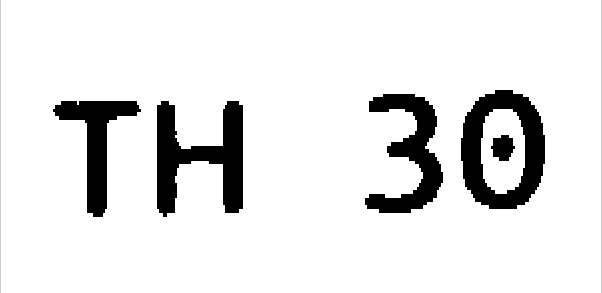

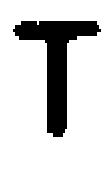

In [ ]:
im_1 = cv2.imread('/content/zero_plate.png')
im_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_1)
f, s, t, fo = split_plates(im_1)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('T')
chars.append('H')
chars.append('3')
chars.append('0')

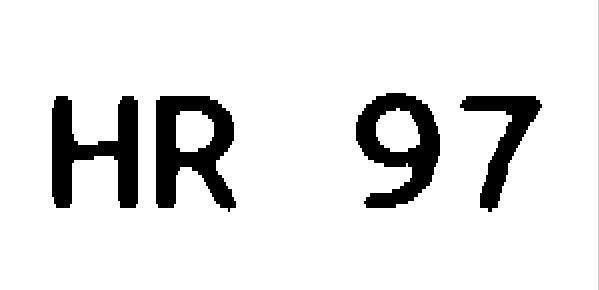

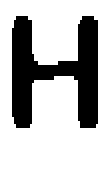

In [ ]:
im_2 = cv2.imread('/content/plate1.png')
im_2 = cv2.cvtColor(im_2, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_2)
f, s, t, fo = split_plates(im_2)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('H')
chars.append('R')
chars.append('9')
chars.append('7')

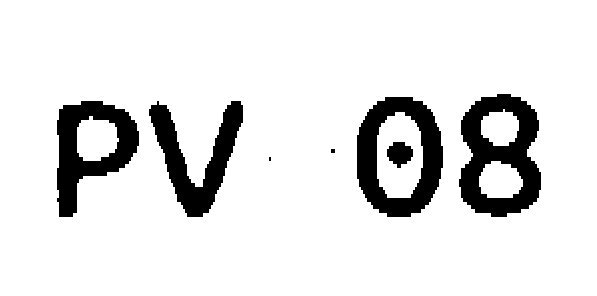

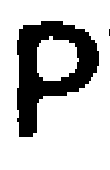

In [ ]:
im_2 = cv2.imread('/content/plate2.png')
im_2 = cv2.cvtColor(im_2, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_2)
f, s, t, fo = split_plates(im_2)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('P')
chars.append('V')
chars.append('0')
chars.append('8')

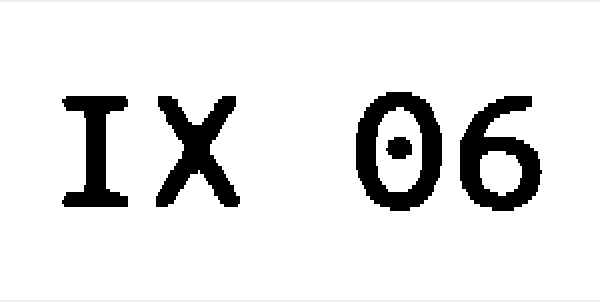

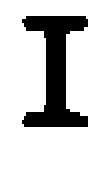

In [ ]:
im_3 = cv2.imread('/content/plate3.png')
im_3 = cv2.cvtColor(im_3, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_3)
f, s, t, fo = split_plates(im_3)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('I')
chars.append('X')
chars.append('0')
chars.append('6')

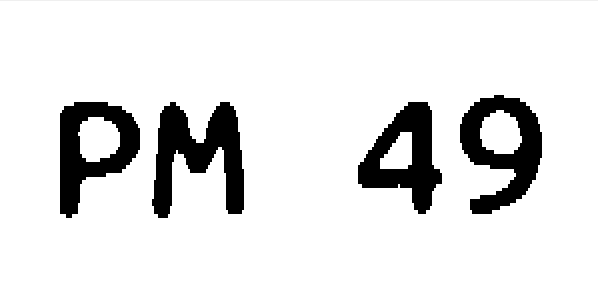

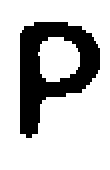

In [ ]:
im_4 = cv2.imread('/content/plate4.png')
im_4 = cv2.cvtColor(im_4, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_4)
f, s, t, fo = split_plates(im_4)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('P')
chars.append('M')
chars.append('4')
chars.append('9')

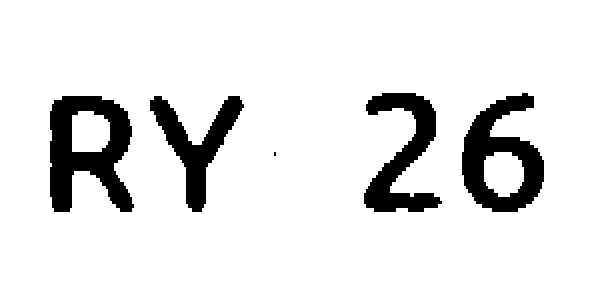

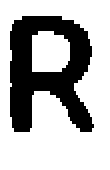

In [ ]:
im_5 = cv2.imread('/content/plate5.png')
im_5 = cv2.cvtColor(im_5, cv2.COLOR_BGR2GRAY)
cv2_imshow(im_5)
f, s, t, fo = split_plates(im_5)
cv2_imshow(f)

In [ ]:
chars_new.append(f)
chars_new.append(s)
chars_new.append(t)
chars_new.append(fo)

chars.append('R')
chars.append('Y')
chars.append('2')
chars.append('6')

In [ ]:
# matches each character to a number
encoding = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11,
    'M': 12,
    'N': 13,
    'O': 14,
    'P': 15,
    'Q': 16,
    'R': 17,
    'S': 18,
    'T': 19,
    'U': 20,
    'V': 21,
    'W': 22,
    'X': 23,
    'Y': 24,
    'Z': 25,
    '0': 26,
    '1': 27,
    '2': 28,
    '3': 29,
    '4': 30,
    '5': 31,
    '6': 32,
    '7': 33,
    '8': 34,
    '9': 35,
}

# adds the number associated with each character in chars to the encoded list
def encode(chars):
  encoded = []
  for element in chars:
    encoded.append(encoding[element])
  return encoded

encoded = encode(chars)

In [ ]:
# creates an array where each element has the character image and its number
imgset = np.array([[np.array(chars_new[i]), encoded[i]] for i in range(0, len(encoded))])

<ipython-input-31-3033c9ca45e7>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgset = np.array([[np.array(chars_new[i]), encoded[i]] for i in range(0, len(encoded))])


In [ ]:
np.random.shuffle(imgset)

In [ ]:
x_dataset = np.array([data[0] for data in imgset[:]]).reshape(2424, 170, 110, -1)

In [ ]:
y_dataset = np.array([[data[1]] for data in imgset]).T

In [ ]:
NUMBER_OF_LABELS = 36
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = x_dataset/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(y_dataset, NUMBER_OF_LABELS).T

In [ ]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 2424
Training examples: 1940
Test examples: 484
X shape: (2424, 170, 110, 1)
Y shape: (2424, 36)


In [ ]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  X_orig_shape = X_dataset.reshape(2424, 170, 110)
  plt.imshow(X_orig_shape[index])
  caption = ("y = " + str(Y_dataset[index]))#str(np.squeeze(Y_dataset_orig[:, index])))
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 20,
           horizontalalignment='left', verticalalignment='top')


interact(displayImage, 
         index=ipywidgets.IntSlider(min=0, max=x_dataset.shape[0],
                                    step=1, value=10))
#displayImage(2)

interactive(children=(IntSlider(value=10, description='index', max=2424), Output()), _dom_classes=('widget-int…

<function __main__.displayImage(index)>

In [ ]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(170, 110, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [ ]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 108, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 54, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 52, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 12, 128)      0

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [ ]:
reset_weights(conv_model)

In [ ]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=10, 
                              batch_size=16)

Epoch 1/10
122/122 [==============================] - 14s 32ms/step - loss: 2.4134 - acc: 0.3987 - val_loss: 0.9776 - val_acc: 0.7052
Epoch 2/10
122/122 [==============================] - 2s 17ms/step - loss: 0.2618 - acc: 0.9407 - val_loss: 0.0224 - val_acc: 1.0000
Epoch 3/10
122/122 [==============================] - 4s 29ms/step - loss: 0.0511 - acc: 0.9856 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 4/10
122/122 [==============================] - 3s 28ms/step - loss: 0.0231 - acc: 0.9933 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 5/10
122/122 [==============================] - 2s 16ms/step - loss: 0.0192 - acc: 0.9948 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 6/10
122/122 [==============================] - 2s 20ms/step - loss: 0.0067 - acc: 0.9985 - val_loss: 3.1201e-04 - val_acc: 1.0000
Epoch 7/10
122/122 [==============================] - 2s 18ms/step - loss: 0.0041 - acc: 0.9990 - val_loss: 2.8764e-04 - val_acc: 1.0000
Epoch 8/10
122/122 [==============================] - 2s 17m

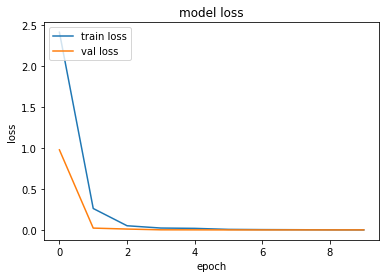

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

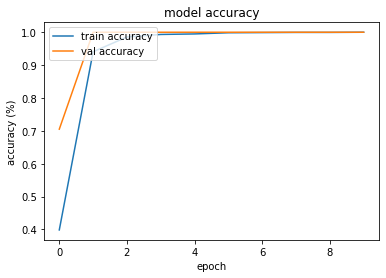

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
# get numbers from one hot encoding
numbers_new = []
for y in Y_dataset:
   for index in range(0, len(y)):
     if y[index] != 0:
       numbers_new.append(index)

In [ ]:
# matches each number to a letter
number_encoding = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z',
    26: '0',
    27: '1',
    28: '2',
    29: '3',
    30: '4',
    31: '5',
    32: '6',
    33: '7',
    34: '8',
    35: '9',
}

y_true = []
for number in numbers_new:
  y_true.append(number_encoding[number])

In [ ]:
y_pred = []

for img in X_dataset:
  # use model to make character prediction based on input image
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]

  # get make value from y_predict and convert it to its associate character
  predictions = y_predict.tolist()
  max_value = max(predictions)
  max_index = predictions.index(max_value)
  y_pred.append(number_encoding[max_index])

1/1 [==============================] - 0s 19ms/step


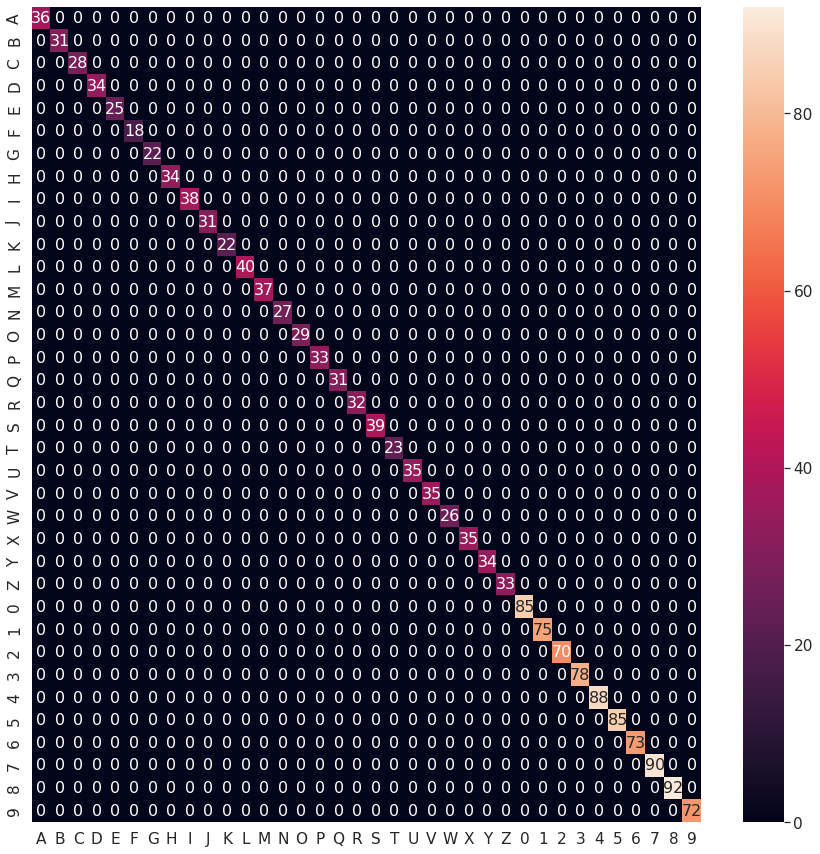

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# plot confusion matrix

matrix = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C','D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

df_cm = pd.DataFrame(matrix, 
                     index=['A', 'B', 'C','D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                     columns=['A', 'B', 'C','D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
# matches each number to a letter
number_encoding = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z',
    26: '0',
    27: '1',
    28: '2',
    29: '3',
    30: '4',
    31: '5',
    32: '6',
    33: '7',
    34: '8',
    35: '9',
}

y_true = []
for number in numbers_new:
  y_true.append(number_encoding[number])

In [ ]:
# predict a license plate
letter = chars_new[5]

new_y_pred = ""

# use model to make character prediction based on input image
img_aug = np.expand_dims(letter, axis=0)
y_predict = conv_model.predict(img_aug)[0]

# get make value from y_predict and convert it to its associate character
predictions = y_predict.tolist()
max_value = max(predictions)
max_index = predictions.index(max_value)
new_y_pred += number_encoding[max_index]

1/1 [==============================] - 0s 199ms/step


In [ ]:
# predict a license plate
letter = chars_new[0]

new_y_pred = ""

# use model to make character prediction based on input image
img_aug = np.expand_dims(letter, axis=0)
y_predict = conv_model.predict(img_aug)[0]

# get make value from y_predict and convert it to its associate character
predictions = y_predict.tolist()
max_value = max(predictions)
max_index = predictions.index(max_value)
new_y_pred += number_encoding[max_index]

1/1 [==============================] - 0s 123ms/step


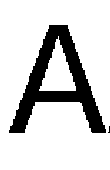

Prediction: 
A


In [ ]:
cv2_imshow(letter)
print("Prediction: ")
print(new_y_pred)

In [ ]:
# serialize model to JSON
model_json = conv_model.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
conv_model.save_weights("model_new.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")